In [23]:
#Zohd Khan
#Updated: 12/15/2023

#Code outline (Zohd's Part)
#Section 1
  #WHO Data Fetching
    # Data Preparation
      # Visualization 1: Life Expectancy over Time
      # Visualization 2: Life Expectancy by Gender
      # Visualization 3: Government Health Expenditure per Capita
      # Visualization 4: Mortality by Communicable Diseases Heatmap

#Section 2
  #World Bank Data Fetch & Preparation
      # Visual 1: GDP Per Capita Visualization
      # Visual 2: Adult Mortality Rate Visualization


#Importing neccesary modules
import requests # HTTP request lib
import pandas as pd #  data processing, Dataframe creation and manipulation
import matplotlib.pyplot as plt # Data visualization (Charts)
import seaborn as sns # Data visualization (attractive and informative Charts)
import numpy as np # Numerical calculations


# ----- Data Fetching --------------------------------------

#Code below sets WHO API URL, country codes in scope for analysis
#Indicator codes for various health indicators for specific type og health-related data

base_url = "https://ghoapi.azureedge.net/api/" # Placing the base_url used for the GHO API request

countries = ["IND", "USA", "CHN"] #Creating countries list for the 3 main countries focused on for first main topic question
indicator_codes = [
    "WHOSIS_000007", "WHOSIS_000001", "MALARIA_EST_MORTALITY", 
    "WHS2_138", "CHOLERA_0000000003", "MDG_0000000017", "GHED_GGHE-D_pc_US_SHA2011" # List of Indicator Codes used to fetch the data
]

# This function takes 2 lists defined above, creates empty dictionary, constructs appropriate URL, makes API request, and stores DFs in 
# the empty dictionary with different key as the function iterates through the indicator and country (which correspond to each df)
def fetch_data_for_country(indicator_codes, country_code): 
    dataframes = {} #Creating empty dictionary to store dataframes
    for indicator_code in indicator_codes:
        # Constructing the URL for fetching data for a specific country and indicator, as well as time from 2000-2023, but most data goes until 2019
        url = f"{base_url}{indicator_code}?$filter=SpatialDim eq '{country_code}' and TimeDim ge 2000 and TimeDim le 2023"
        # Making the API request using get method
        response = requests.get(url)
        if response.status_code == 200: #if getting success code, getting the response in JSON format
            data = response.json().get('value', [])
            if data:
                key = f"{country_code}_{indicator_code}" #Creating naming convention for dfs as the key in the key-value pair for the "dataframes" dict
                dataframes[key] = pd.DataFrame(data) #For each key (each indicator/country combo) storing data in PD df, each of which goes in 
                # "dataframes" dict
        else:
            print(f"Error: Unable to fetch data for {indicator_code}. Status code: {response.status_code}") #Printing message in case of error
    return dataframes #Returning the local dataframes dict

# Creating global dictionary to store all DataFrames to be able to access outside the main function
all_dataframes = {}
# Fetching data for each country and storing it in the all_dataframes dictionary
for country_code in countries:
    country_data = fetch_data_for_country(indicator_codes, country_code) #Calling the main function for GHO API request
    all_dataframes.update(country_data) #Appending/updating the global dict with each dataframe

In [24]:
# ----- Data Preparation --------------------------------------

# Consolidating DataFrames into one using the concat function 
india_df = all_dataframes['IND_WHOSIS_000001'] #Dataframe for life expectancy at birth in India
china_df = all_dataframes['CHN_WHOSIS_000001']#Dataframe for life expectancy at birth in China
usa_df = all_dataframes['USA_WHOSIS_000001'] #Dataframe for life expectancy at birth in USA
combined_df = pd.concat([india_df, china_df, usa_df], ignore_index=True)

# Removing columns that were either almost empty or not deemed useful  by first making list of columns to remove
columns_to_remove = ['Dim2Type', 'Dim2', 'Dim3Type', 'Dim3', 'DataSourceDimType', 'Low', 'High',
'ParentLocationCode', 'Dim1Type', 'DataSourceDim', 'Comments']
combined_df.drop(columns_to_remove, axis=1, inplace=True) #Using drop method to conduct the actual removal

# Standardizing gender values for formality when displaying on plots 
gender_map = {'MLE': 'Male', 'FMLE': 'Female', 'BTSX': 'Both'}
combined_df['Dim1'] = combined_df['Dim1'].map(gender_map)

# Converting 'Date' to datetime and extracting year
combined_df['Year'] = pd.to_datetime(combined_df['Date']).dt.year

# Converting data types required for charting
combined_df['Value'] = combined_df['Value'].astype(float) #Setting values in Value column to type float
combined_df['NumericValue'] = combined_df['NumericValue'].astype(float) #Setting values in NumericValue column to type float
combined_df['CountryCode'] = combined_df['SpatialDim'].astype('category') #Setting values in SpatialDim column as categories
combined_df['Gender'] = combined_df['Dim1'].astype('category') #Setting gender column to the name it has in actual data, and setting its values
#as categories
combined_df.dropna(inplace=True) #Lastly dropping all other NA/null values

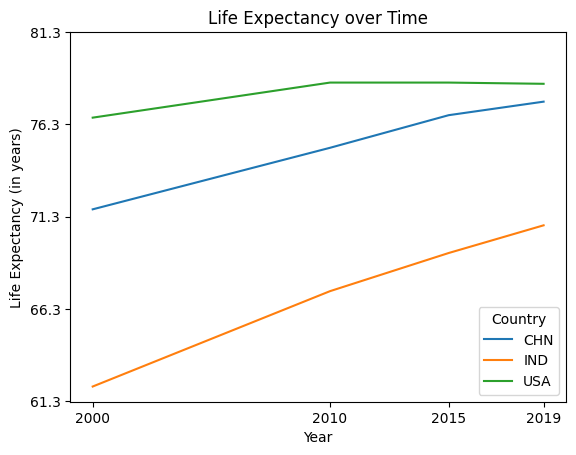

In [25]:
# ----- Visualization 1: Life Expectancy over Time --------------------------------------

# Making code for the desired interval for the years on the x-axis 
unique_years = combined_df['TimeDim'].unique()
min_value = combined_df['Value'].min() #Setting min interval as min value from Value column 
max_value = combined_df['Value'].max() #Setting max interval as max value from Value column 
y_tick_interval = 5 #Setting a gap of 5 between each interval on the y-axis
y_ticks = np.arange(start=min_value, stop=max_value + y_tick_interval, step=y_tick_interval) #Using arange method to get desired range for y-axis 
#intervals
#Using lineplot method from Seaborn module to plot combined_df data and setting appropriate parameters
sns.lineplot(data=combined_df, x='TimeDim', y='Value', hue='CountryCode', errorbar = None)
plt.title('Life Expectancy over Time') #Setting Title
plt.xlabel('Year') #Setting x-axis title
plt.ylabel('Life Expectancy (in years)') #Setting y-axis title
plt.xticks(unique_years) #Setting the intervals for x-axis using code from start of cell
plt.yticks(y_ticks) #Setting intervals for y-axis from code from start of cell
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[0:], labels=labels[0:], title='Country', loc='lower right')
plt.show()

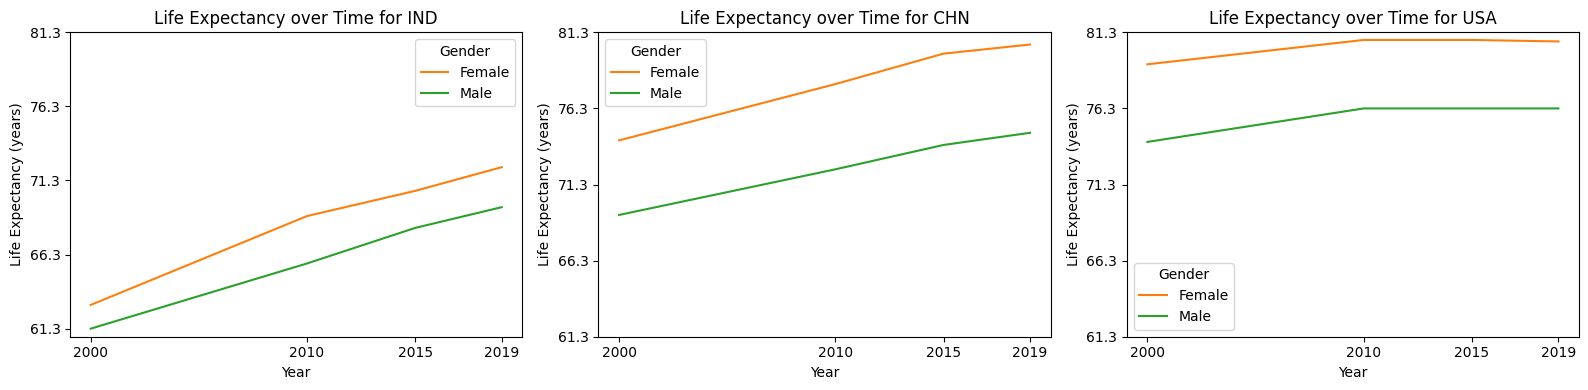

In [26]:
# ----- Visualization 2: Life Expectancy by Gender --------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 4)) #Using subplots method from matplotlib module to get figure with 3 subplots
countries = combined_df['CountryCode'].unique() #Getting the countries to be seperate for this visualization as we plot them seperately

for i, country in enumerate(countries): # for loop to iterate through countries plot differences in life expectancy between genders for each country
    country_df = combined_df[(combined_df['CountryCode'] == country) & (combined_df['Gender'] != 'Both')] #Iterating through the CountryCode column 
    #to go account for the 3 countries and taking out both value for gender since we are only considering male and female values here
    sns.lineplot(data=country_df, x='TimeDim', y='Value', hue='Gender', ax=axes[i])# Using lineplot method from seaborn to plot
    axes[i].set_title(f'Life Expectancy over Time for {country}') #Setting title for each i 
    axes[i].set_xlabel('Year') #Setting x-axis title for each i
    axes[i].set_ylabel('Life Expectancy (years)') #Setting y-axis label for each i
    axes[i].set_xticks(unique_years) #Setting xticks as unique years
    axes[i].set_yticks(y_ticks) #Setting yticks to what we need
    handles, labels = axes[i].get_legend_handles_labels() #Writing code to get the legend to display based on the different gender values
    axes[i].legend(handles=handles[1:], labels=labels[1:], title='Gender')

plt.tight_layout()
plt.show() #Showing the plot in a tight layout

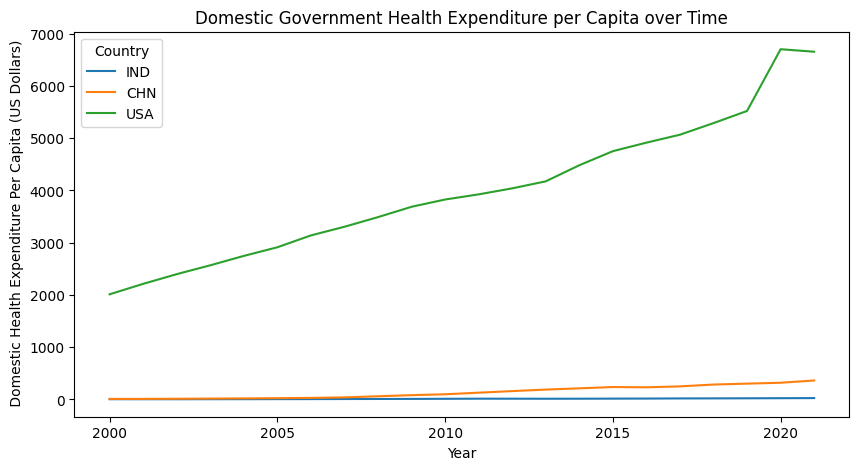

In [30]:
# ----- Visualization 3: Government Health Expenditure per Capita --------------------------------------
all_health_data = pd.DataFrame() #Creating a empty Pandas dataframe 
for country in countries: #Iterating for countries 
    country_health_data = fetch_data_for_country(["GHED_GGHE-D_pc_US_SHA2011"], country) # Calling function to population the dataframe
    for key, df in country_health_data.items():
        df['Country'] = country
        all_health_data = pd.concat([all_health_data, df], ignore_index=True)
# Building the x and y axes 
all_health_data['Year'] = all_health_data['TimeDim'].astype(str).str[:4].astype(int) 
all_health_data['NumericValue'] = all_health_data['Value'].str.split().str.get(0).astype(float)
#Creating the plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_health_data, x='Year', y='NumericValue', hue='Country')
plt.xlabel('Year')
plt.ylabel(' Domestic Health Expenditure Per Capita (US Dollars)')
plt.title('Domestic Government Health Expenditure per Capita over Time')
plt.show()

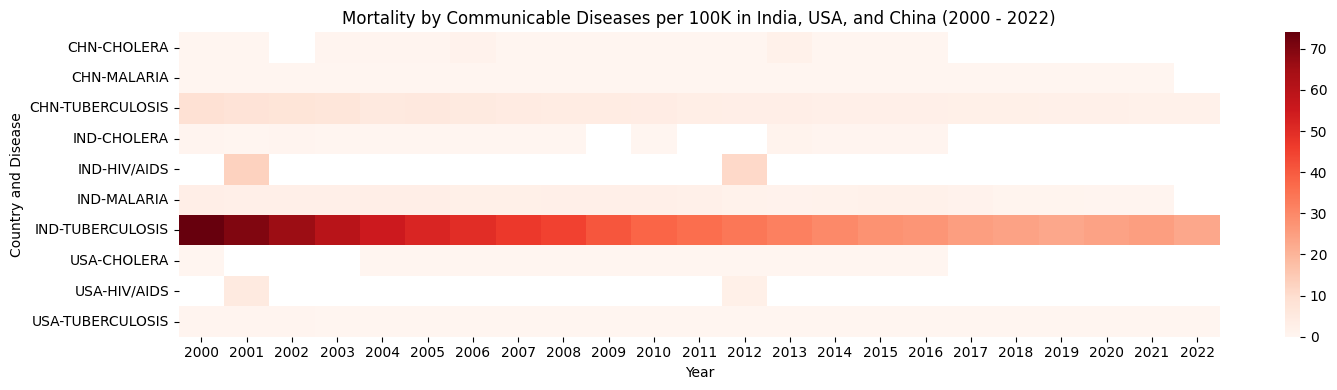

In [31]:
# ----- Visualization 4: Mortality by Communicable Diseases Heatmap --------------------------------------

# Dictionary mapping diseases to their respective indicator codes
indicator_codes_diseases = {
    "MALARIA": "MALARIA_EST_MORTALITY",
    "HIV/AIDS": "WHS2_138",
    "CHOLERA": "CHOLERA_0000000003",
    "TUBERCULOSIS": "MDG_0000000017"
}

# Function to fetch data for a specific disease using the API for each country
def fetch_data_for_disease(indicator_code, countries):
    all_data = pd.DataFrame()  # Initializing an empty DataFrame to store all data
    for country_code in countries:
        url = f"{base_url}{indicator_code}?$filter=SpatialDim eq '{country_code}'"  # Constructing the API URL
        response = requests.get(url)  # Making an HTTP GET request to the API
        if response.status_code == 200:  # Checking if the request was successful
            data = response.json().get('value', [])  # Extracting data from the response
            df = pd.DataFrame(data)  # Converting the data into a DataFrame
            df['Country'] = country_code  # Adding a column for the country code
            df = df.dropna(axis=1, how='all')
            all_data = pd.concat([all_data, df])  # Appending the data to the all_data DataFrame
        else:
            # Printing an error message if data fetching fails
            print(f"Error fetching data for {country_code}: {response.status_code}")
    return all_data  # Returning the compiled data

# Creating a DataFrame to combine data for all diseases
combined_data_diseases = pd.DataFrame()
for disease, code in indicator_codes_diseases.items():
    df = fetch_data_for_disease(code, countries)  # Fetching data for each disease
    df['Disease'] = disease  # Adding a column for the disease name
    combined_data_diseases = pd.concat([combined_data_diseases, df])  # Combining the data

# Extracting the year from the 'TimeDim' column, if it exists
if 'TimeDim' in combined_data_diseases.columns:
    combined_data_diseases['Year'] = combined_data_diseases['TimeDim'].astype(str).str[:4].astype(int)
else:
    # Printing an error message if 'TimeDim' column is missing
    print("The column 'TimeDim' does not exist. Please check the data source.")

# Filtering data to include only years from 2000 onwards
combined_data_diseases = combined_data_diseases[combined_data_diseases['Year'] >= 2000]

# Extracting and converting the numeric value from the 'Value' column, if it exists
if 'Value' in combined_data_diseases.columns:
    combined_data_diseases['NumericValue'] = combined_data_diseases['Value'].str.split().str.get(0)
    combined_data_diseases['NumericValue'] = pd.to_numeric(combined_data_diseases['NumericValue'], errors='coerce')
else:
    # Printing an error message if 'Value' column is missing
    print("The column 'Value' does not exist. Please check the data source.")

# Preparing data for the heatmap
heatmap_data = pd.DataFrame()
if 'Year' in combined_data_diseases.columns and 'Disease' in combined_data_diseases.columns and 'NumericValue' in combined_data_diseases.columns and 'Country' in combined_data_diseases.columns:
    # Creating a pivot table for the heatmap
    heatmap_data = combined_data_diseases.pivot_table(index=['Country', 'Disease'], columns='Year', values='NumericValue', aggfunc='sum')
    heatmap_data = heatmap_data.sort_index(level=['Country', 'Disease'], ascending=[True, True])
else:
    # Printing an error message if required columns are missing for the pivot table
    print("Cannot create a pivot table. Required columns are missing.")

# Plotting the heatmap if data is available
if not heatmap_data.empty:
    plt.figure(figsize=(15, 4))  # Setting the figure size
    sns.heatmap(heatmap_data, cmap="Reds", cbar=True, annot=False)  # Creating a heatmap
    plt.title("Mortality by Communicable Diseases per 100K in India, USA, and China (2000 - 2022)")  # Setting the title
    plt.xlabel("Year")  # Setting the x-axis label
    plt.ylabel("Country and Disease")  # Setting the y-axis label
    ax = plt.gca()  # Getting the current axes
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')  # Adjusting y-axis labels
    ax.tick_params(axis='y', which='major', labelsize=10, labelcolor='black')  # Customizing tick parameters
    plt.tight_layout()  # Adjusting the layout
    plt.show()  # Displaying the plot
else:
    # Printing error message in case of error 
    print("No data available to create a heatmap.")

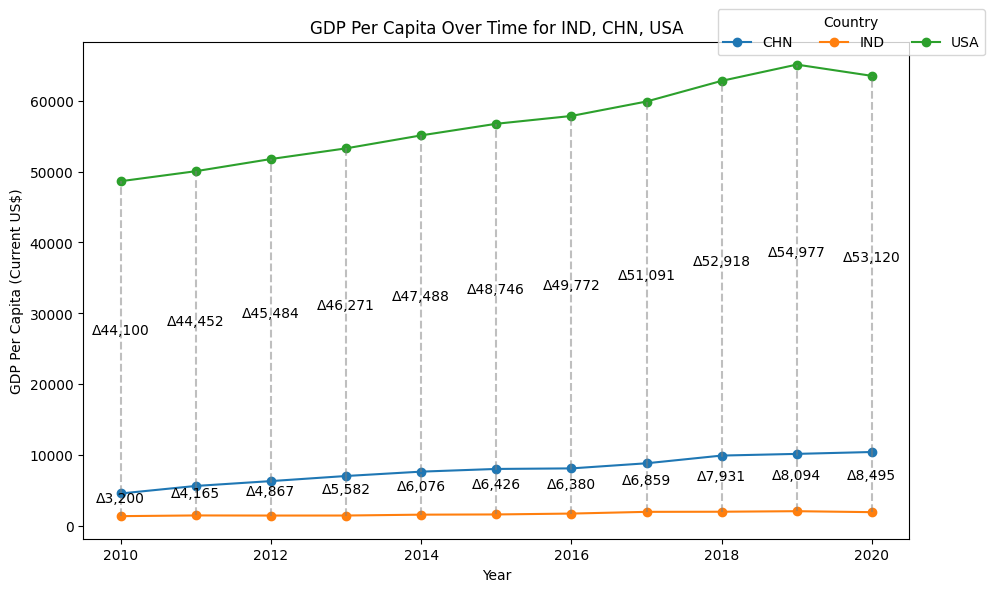

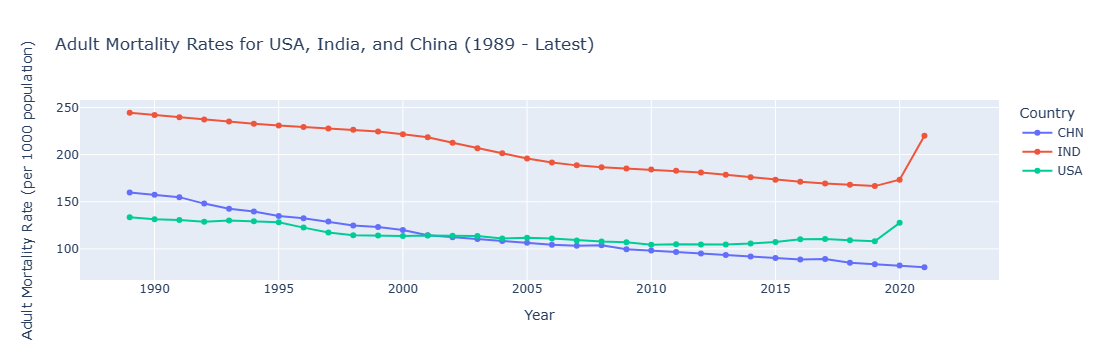

In [45]:
# Import necessary libraries
import wbgapi as wb  # Importing World Bank API for accessing economic data
import pandas as pd  # Importing pandas for data manipulation
import matplotlib.pyplot as plt  # Importing matplotlib for plotting static visualizations
import plotly.express as px  # Importing Plotly Express for interactive visualizations

# ----- Data Fetch & Preparation --------------------------------------
# Retrieving GDP per capita data for India, China, and USA from 2010 to 2021
df_gdp = wb.data.DataFrame('NY.GDP.PCAP.CD', ['IND', 'CHN', 'USA'], range(2010, 2021))  # Fetching GDP per capita data

# Transforming the data from wide format to long format for easier plotting
df_gdp_long = df_gdp.reset_index().melt(id_vars='economy', var_name='Year', value_name='GDP Per Capita')
df_gdp_long['Year'] = df_gdp_long['Year'].str.replace('YR', '').astype(int)  # Converting Year from string to integer

# Adult Mortality Rate Data Fetch & Preparation
df_male = wb.data.DataFrame('SP.DYN.AMRT.MA', ['USA', 'IND', 'CHN'], time=range(1989, 2023))  # Fetching male adult mortality rate
df_female = wb.data.DataFrame('SP.DYN.AMRT.FE', ['USA', 'IND', 'CHN'], time=range(1989, 2023))  # Fetching female adult mortality rate
df_mortality = (df_male + df_female) / 2  # Averaging male and female rates
df_mortality_long = df_mortality.reset_index().melt(id_vars='economy', var_name='Year', value_name='Adult Mortality Rate')
df_mortality_long['Year'] = df_mortality_long['Year'].str.replace('YR', '').astype(int)  # Converting Year from string to integer

# ----- Visual 1: GDP Per Capita Visualization --------------------------------------
# Plot the transformed data
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure and axis for the plot
# Looping through each country to plot their GDP per capita over time
for country_code in df_gdp_long['economy'].unique():
    country_data = df_gdp_long[df_gdp_long['economy'] == country_code]
    ax.plot(country_data['Year'], country_data['GDP Per Capita'], marker='o', label=wb.economy.coder(country_code))

# Add vertical lines to demonstrate differences between countries' GDP per capita
for year in range(2010, 2021):
    year_data = df_gdp_long[df_gdp_long['Year'] == year].sort_values('GDP Per Capita')
    for i in range(len(year_data) - 1):
        lower_country = year_data.iloc[i]
        upper_country = year_data.iloc[i+1]
        ax.vlines(year, lower_country['GDP Per Capita'], upper_country['GDP Per Capita'], colors='grey', linestyles='dashed', alpha=0.5)
        mid_point = (lower_country['GDP Per Capita'] + upper_country['GDP Per Capita']) / 2
        diff = upper_country['GDP Per Capita'] - lower_country['GDP Per Capita']
        ax.text(year, mid_point, f'Δ{diff:,.0f}', horizontalalignment='center', verticalalignment='bottom')

# Customize plot
plt.xlabel('Year')
plt.ylabel('GDP Per Capita (Current US$)')
plt.title('GDP Per Capita Over Time for IND, CHN, USA')
ax.legend(title='Country', loc='upper right', bbox_to_anchor=(1.1, 1.08), ncol=3)
plt.grid(False)
plt.tight_layout()
plt.show()

# ----- Visual 2: Adult Mortality Rate Visualization --------------------------------------
# Create an interactive line plot using plotly
fig = px.line(df_mortality_long,
              x='Year',
              y='Adult Mortality Rate',
              color='economy',
              labels={'economy': 'Country', 'Adult Mortality Rate': 'Adult Mortality Rate (per 1000 population)'},
              title='Adult Mortality Rates for USA, India, and China (1989 - Latest)',
              markers=True)

# Update traces and layout for clarity and interactivity
fig.update_traces(mode='lines+markers', hoverinfo='all')
fig.update_layout(yaxis_title='Adult Mortality Rate (per 1000 population)', height=500)  # Height set to 500 pixels for better readability

# Show the plot

fig.show()


In [32]:
#Asuka Iwamoto
#Updated: 12/15/2023


#Code outline (Asuka's Part)
#Section 3
  #WHO Data

import requests
import xml.etree.ElementTree as ET
import pandas as pd

#Life expectancy throughout the years

def fetch_life_expectancy_data(country_code):
    # URL for the WHO Athena API endpoint for life expectancy data
    url = f"http://apps.who.int/gho/athena/api/GHO/WHOSIS_000001?filter=COUNTRY:{country_code}"

    # Sending a GET request to the API
    response = requests.get(url)

    # Checking if the request was successful
    if response.status_code == 200:
        # Parsing the XML response
        root = ET.fromstring(response.content)

        # Find the 'Data' element
        data_element = root.find('Data')

        if data_element is not None:
            life_expectancy_data = []

            # Iterate through each 'Observation' in the 'Data' element
            for observation in data_element.findall('Observation'):
                observation_data = {}

                # Iterate through each child of the 'Observation' element
                for child in observation:
                    if child.tag == 'Dim':
                        observation_data[child.attrib['Category']] = child.attrib['Code']
                    elif child.tag == 'Value':
                        observation_data['Value'] = child.attrib['Numeric']

                life_expectancy_data.append(observation_data)

            return life_expectancy_data
        else:
            print("No 'Data' element found in the XML.")
            return None
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return None

# Developed countries
USA_data = fetch_life_expectancy_data("USA")
CHN_data = fetch_life_expectancy_data("CHN")
DEU_data = fetch_life_expectancy_data("DEU")
BTN_data = fetch_life_expectancy_data("BTN")
BWA_data = fetch_life_expectancy_data("BWA")
VEN_data = fetch_life_expectancy_data("VEN")

# Developing countries
USA_df = pd.DataFrame(USA_data)
CHN_df = pd.DataFrame(CHN_data)
DEU_df = pd.DataFrame(DEU_data)
BTN_df = pd.DataFrame(BTN_data)
BWA_df = pd.DataFrame(BWA_data)
VEN_df = pd.DataFrame(VEN_data)

# Display the data in a more organized way
print("Life Expectancy Data for USA:")
print(USA_df)

print("\nLife Expectancy Data for China:")
print(CHN_df)

print("\nLife Expectancy Data for Gernmany:")
print(DEU_df)

print("Life Expectancy Data for Bhutan:")
print(BTN_df)

print("\nLife Expectancy Data for Bostwana:")
print(BWA_df)

print("\nLife Expectancy Data for Venezeula:")
print(VEN_df)


Life Expectancy Data for USA:
   REGION   SEX            GHO  YEAR COUNTRY PUBLISHSTATE     Value
0     AMR   MLE  WHOSIS_000001  2000     USA    PUBLISHED  74.12286
1     AMR   MLE  WHOSIS_000001  2010     USA    PUBLISHED  76.27111
2     AMR   MLE  WHOSIS_000001  2015     USA    PUBLISHED  76.30525
3     AMR   MLE  WHOSIS_000001  2019     USA    PUBLISHED  76.28124
4     AMR  FMLE  WHOSIS_000001  2000     USA    PUBLISHED  79.16907
5     AMR  FMLE  WHOSIS_000001  2010     USA    PUBLISHED  80.80196
6     AMR  FMLE  WHOSIS_000001  2015     USA    PUBLISHED  80.79853
7     AMR  FMLE  WHOSIS_000001  2019     USA    PUBLISHED  80.72668
8     AMR  BTSX  WHOSIS_000001  2000     USA    PUBLISHED  76.69160
9     AMR  BTSX  WHOSIS_000001  2010     USA    PUBLISHED  78.56299
10    AMR  BTSX  WHOSIS_000001  2015     USA    PUBLISHED  78.55634
11    AMR  BTSX  WHOSIS_000001  2019     USA    PUBLISHED  78.49568

Life Expectancy Data for China:
     SEX  YEAR COUNTRY            GHO REGION PUBLISHS

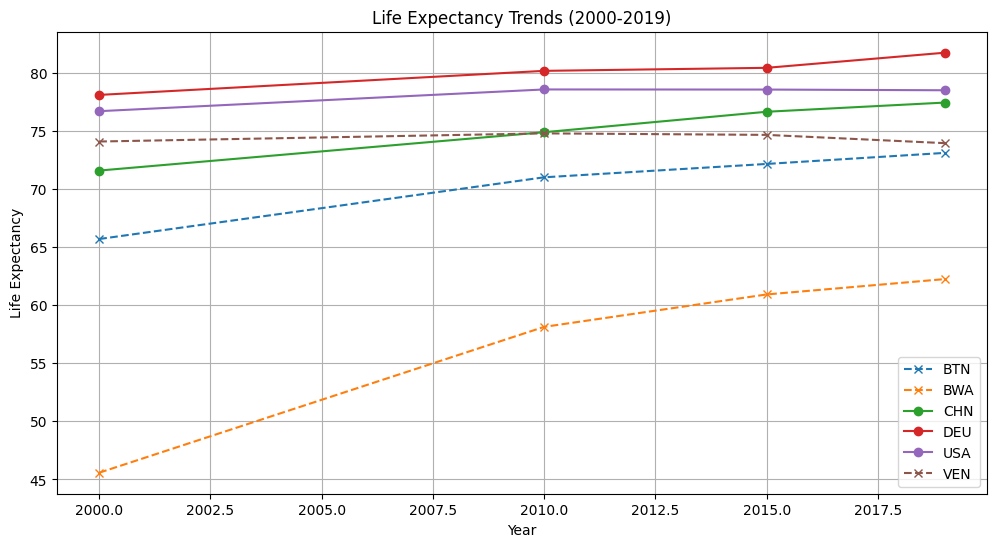

In [33]:
#life expectancy for all 6 countries
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for life expectancy from the provided text
data = {
    "Country": ["USA", "USA", "USA", "USA", "CHN", "CHN", "CHN", "CHN", "DEU", "DEU", "DEU", "DEU", 
                "BTN", "BTN", "BTN", "BTN", "BWA", "BWA", "BWA", "BWA", "VEN", "VEN", "VEN", "VEN"],
    "Year": [2000, 2010, 2015, 2019, 2000, 2010, 2015, 2019, 2000, 2010, 2015, 2019, 
             2000, 2010, 2015, 2019, 2000, 2010, 2015, 2019, 2000, 2010, 2015, 2019],
    "Life Expectancy": [76.69, 78.56, 78.55, 78.49, 71.58, 74.88, 76.64, 77.43, 78.09, 80.16, 80.42, 81.72,
                        65.69, 71.00, 72.15, 73.10, 45.58, 58.13, 60.92, 62.24, 74.08, 74.78, 74.65, 73.94]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))

# Grouping by country and plotting each country with a different color
for country, group in df.groupby("Country"):
    if country in ["USA", "CHN", "DEU"]:
        plt.plot(group["Year"], group["Life Expectancy"], label=country, marker='o')
    else:
        plt.plot(group["Year"], group["Life Expectancy"], label=country, linestyle='--', marker='x')

plt.title("Life Expectancy Trends (2000-2019)")
plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
#Infant mortality rate



def fetch_and_parse_data(indicator_code, country_code):
    url = f"http://apps.who.int/gho/athena/api/GHO/{indicator_code}.xml?filter=COUNTRY:{country_code}"
    response = requests.get(url)

    if response.status_code == 200:
        root = ET.fromstring(response.content)
        data = []

        for observation in root.findall('.//Observation'):
            observation_data = {
                'YEAR': None,
                'COUNTRY': country_code,
                'VALUE': None
            }

            for dim in observation.findall('Dim'):
                if dim.get('Category') == 'YEAR':
                    observation_data['YEAR'] = dim.get('Code')
                elif dim.get('Category') == 'COUNTRY':
                    observation_data['COUNTRY'] = dim.get('Code')

            value = observation.find('Value')
            if value is not None:
                observation_data['VALUE'] = value.get('Numeric')

            data.append(observation_data)

        return pd.DataFrame(data)

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return pd.DataFrame()

# Example usage

indicator_code = 'MDG_0000000001'  # Replace with desired indicator code

US_infant_mortality = fetch_and_parse_data(indicator_code, "USA")
CHN_infant_mortality = fetch_and_parse_data(indicator_code, "CHN")
DEU_infant_mortality = fetch_and_parse_data(indicator_code, "DEU")
BTN_infant_mortality= fetch_and_parse_data(indicator_code, "BTN")
BWA_infant_mortality = fetch_and_parse_data(indicator_code, "BWA")
VEN_infant_mortality = fetch_and_parse_data(indicator_code, "VEN")

print("Infant mortality rates for USA:")
print(US_infant_mortality.tail(21))
print("Infant mortality rates for China:")
print(CHN_infant_mortality.tail(21))
print("Infant mortality rates for Germany:")
print(DEU_infant_mortality.tail(21))
print("Infant mortality rates for Bhutan:")
print(BTN_infant_mortality.tail(21))
print("Infant mortality rates for Botswana:")
print(BWA_infant_mortality.tail(21))
print("Infant mortality rates for Venezuela:")
print(VEN_infant_mortality.tail(21))


Infant mortality rates for USA:
     YEAR COUNTRY    VALUE
196  2001     USA  7.02379
197  2002     USA  6.94746
198  2003     USA  6.88070
199  2004     USA  6.81558
200  2005     USA  6.74499
201  2006     USA  6.66679
202  2007     USA  6.57400
203  2008     USA  6.47058
204  2009     USA  6.35944
205  2010     USA  6.24657
206  2011     USA  6.13847
207  2012     USA  6.03995
208  2013     USA  5.95310
209  2014     USA  5.87617
210  2015     USA  5.80558
211  2016     USA  5.73693
212  2017     USA  5.66726
213  2018     USA  5.59460
214  2019     USA  5.52011
215  2020     USA  5.44290
216  2021     USA  5.35906
Infant mortality rates for China:
     YEAR COUNTRY     VALUE
138  2001     CHN  27.87967
139  2002     CHN  25.70095
140  2003     CHN  23.52476
141  2004     CHN  21.41840
142  2005     CHN  19.47560
143  2006     CHN  17.73795
144  2007     CHN  16.18591
145  2008     CHN  14.81769
146  2009     CHN  13.60115
147  2010     CHN  12.50486
148  2011     CHN  11.49848
149 

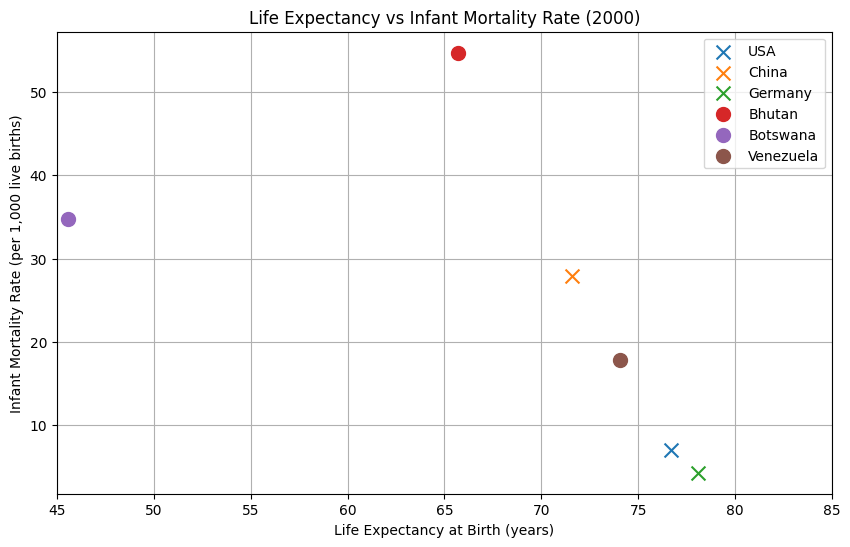

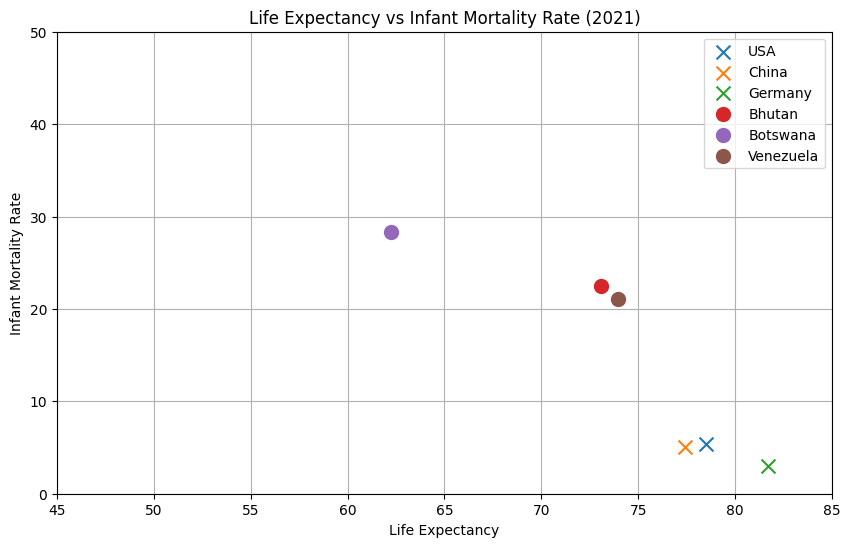

In [35]:

import matplotlib.pyplot as plt

# Sample data for Life Expectancy and Infant Mortality Rate in the year 2000
countries = ['USA', 'China', 'Germany', 'Bhutan', 'Botswana', 'Venezuela']
life_expectancy_2000 = [76.69, 71.58, 78.09, 65.69, 45.58, 74.08]  # Life expectancy data for 2000
imr_2000 = [7.02379, 27.87967, 4.27369, 54.72356, 34.71869, 17.80609]  # Infant mortality rate data for 2000

# Create the scatter plot for Life Expectancy vs Infant Mortality Rate for 2000
plt.figure(figsize=(10, 6))
for i, country in enumerate(countries):
    marker = 'x' if country in ["USA", "China", "Germany"] else 'o'
    plt.scatter(life_expectancy_2000[i], imr_2000[i], label=country, s=100, marker=marker)

# Title and labels
plt.title("Life Expectancy vs Infant Mortality Rate (2000)")
plt.xlabel("Life Expectancy at Birth (years)")
plt.xlim(45,85)
plt.ylabel("Infant Mortality Rate (per 1,000 live births)")
plt.legend()
plt.grid(True)
plt.show()

# Sample data for life expectancy and infant mortality rate in 2020
countries = ['USA', 'China', 'Germany', 'Bhutan', 'Botswana', 'Venezuela']
life_expectancy_2021 = [78.49, 77.43, 81.72, 73.10, 62.24, 73.94]  # Life expectancy data for 2021
infant_mortality_2021 = [5.35906, 5.05007, 3.03109, 22.45237, 28.31408, 21.06303]  # Infant mortality rate data for 2021

# Creating the scatter plot
plt.figure(figsize=(10, 6))
for i, country in enumerate(countries):
    marker = 'x' if country in ["USA", "China", "Germany"] else 'o'
    plt.scatter(life_expectancy_2021[i], infant_mortality_2021[i], label=country, s=100, marker=marker)

plt.title("Life Expectancy vs Infant Mortality Rate (2021)")
plt.xlabel("Life Expectancy")
plt.xlim(45,85)
plt.ylabel("Infant Mortality Rate")
plt.ylim(0, 50)  # Setting maximum y-axis value to 50
plt.legend()
plt.grid(True)
plt.show()




In [36]:
#Maternal Mortality Ratio (per 100,000 births)

import xml.etree.ElementTree as ET
import pandas as pd
import requests

def fetch_and_parse_data(indicator_code, country_code):
    url = f"http://apps.who.int/gho/athena/api/GHO/{indicator_code}.xml?filter=COUNTRY:{country_code}"
    response = requests.get(url)

    if response.status_code == 200:
        root = ET.fromstring(response.content)
        data = []

        for observation in root.findall('.//Observation'):
            observation_data = {
                'YEAR': None,
                'COUNTRY': country_code,
                'VALUE': None
            }

            for dim in observation.findall('Dim'):
                if dim.get('Category') == 'YEAR':
                    observation_data['YEAR'] = dim.get('Code')
                elif dim.get('Category') == 'COUNTRY':
                    observation_data['COUNTRY'] = dim.get('Code')

            value = observation.find('Value')
            if value is not None:
                observation_data['VALUE'] = value.get('Numeric')

            data.append(observation_data)

        return pd.DataFrame(data)

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return pd.DataFrame()

indicator_code = 'MDG_0000000026'  # Replace with desired indicator code
US_maternal_mratio= fetch_and_parse_data(indicator_code, "USA")
CHN_maternal_mratio = fetch_and_parse_data(indicator_code, "CHN")
DEU_maternal_mratio = fetch_and_parse_data(indicator_code, "DEU")
BTN_maternal_mratio= fetch_and_parse_data(indicator_code, "BTN")
BWA_maternal_mratio = fetch_and_parse_data(indicator_code, "BWA")
VEN_maternal_mratio = fetch_and_parse_data(indicator_code, "VEN")

print("Maternal mortality ratio for USA:")
print(US_maternal_mratio.tail(21))
print("Maternal mortality ratio for China:")
print(CHN_maternal_mratio.tail(21))
print("Maternal mortality ratio for Germany:")
print(DEU_maternal_mratio.tail(21))
print("Maternal mortality ratio for Bhutan")
print(BTN_maternal_mratio.tail(21))
print("Maternal mortality ratio for Botswana")
print(BWA_maternal_mratio.tail(21))
print("Maternal mortality ratio for Venezuela")
print(VEN_maternal_mratio.tail(21))



import matplotlib.pyplot as plt

# Sample data for Life Expectancy and Infant Mortality Rate in the year 2000
countries = ['USA', 'China', 'Germany', 'Bhutan', 'Botswana', 'Venezuela']
life_expectancy_2000 = [76.69, 71.58, 78.09, 65.69, 45.58, 74.08]  # Life expectancy data for 2000
maternal_mortality_2000 = [11.82542, 63.09101, 7.16422, 304.68151, 181.55973, 92.40870]  # Maternal mortality rate data for 2000

# Create the scatter plot for Life Expectancy vs Infant Mortality Rate for 2000
plt.figure(figsize=(10, 6))
for i, country in enumerate(countries):
    marker = 'x' if country in ["USA", "China", "Germany"] else 'o'
    plt.scatter(life_expectancy_2000[i], maternal_mortality_2021[i], label=country, s=100, marker=marker)

# Title and labels
plt.title("Life Expectancy vs Maternal Mortality Rate (2000)")
plt.xlabel("Life Expectancy at Birth (years)")
plt.xlim(45,85)
plt.ylabel("Maternal Mortality Rate (per 1,000 live births)")
plt.legend()
plt.grid(True)
plt.show()

# Sample data for life expectancy and infant mortality rate in 2020
countries = ['USA', 'China', 'Germany', 'Bhutan', 'Botswana', 'Venezuela']
life_expectancy_2021 = [78.49, 77.43, 81.72, 73.10, 62.24, 73.94]  # Life expectancy data for 2021
maternal_mortality_2021 = [21.08491, 23.04763, 4.42844, 0, 185.89684, 259.18645]  # Maternal Mortality Ratio data for 2021

# Creating the scatter plot
plt.figure(figsize=(10, 6))
for i, country in enumerate(countries):
    marker = 'x' if country in ["USA", "China", "Germany"] else 'o'
    plt.scatter(life_expectancy_2021[i], maternal_mortality_2021[i], label=country, s=100, marker=marker)

plt.title("Life Expectancy vs Maternal Mortality Rate (2021)")
plt.xlabel("Life Expectancy")
plt.xlim(45,85)  # Setting maximum y-axis value to 50
plt.ylabel("Maternal Mortality Rate")
plt.ylim(-5, 270)  # Setting maximum y-axis value to 50
plt.legend()
plt.grid(True)
plt.show()

Maternal mortality ratio for USA:
    YEAR COUNTRY     VALUE
15  2000     USA  11.82542
16  2001     USA  12.52694
17  2002     USA  12.88114
18  2003     USA  13.17497
19  2004     USA  13.09522
20  2005     USA  13.28030
21  2006     USA  13.19619
22  2007     USA  13.21726
23  2008     USA  13.97374
24  2009     USA  15.40720
25  2010     USA  14.07504
26  2011     USA  15.26360
27  2012     USA  15.82093
28  2013     USA  16.41608
29  2014     USA  16.78385
30  2015     USA  17.37795
31  2016     USA  18.44739
32  2017     USA  19.14315
33  2018     USA  19.45208
34  2019     USA  19.85235
35  2020     USA  21.08491
Maternal mortality ratio for China:
    YEAR COUNTRY      VALUE
15  1998     CHN   63.09101
16  1997     CHN   65.69755
17  1996     CHN   66.49894
18  1995     CHN   76.26866
19  1994     CHN   79.01436
20  1993     CHN   78.22622
21  1992     CHN   89.69512
22  1991     CHN   87.93826
23  1990     CHN   85.91840
24  1989     CHN   89.92267
25  1988     CHN   95.00008


NameError: name 'maternal_mortality_2021' is not defined

<Figure size 1000x600 with 0 Axes>

In [37]:
#Total measles - number of reported cases
indicator_code = 'WHS3_62'  # Replace with desired indicator code

def fetch_and_parse_data(indicator_code, country_code):
    url = f"http://apps.who.int/gho/athena/api/GHO/{indicator_code}.xml?filter=COUNTRY:{country_code}"
    response = requests.get(url)

    if response.status_code == 200:
        root = ET.fromstring(response.content)
        data = []

        for observation in root.findall('.//Observation'):
            observation_data = {
                'YEAR': None,
                'COUNTRY': country_code,
                'VALUE': None
            }

            for dim in observation.findall('Dim'):
                if dim.get('Category') == 'YEAR':
                    observation_data['YEAR'] = dim.get('Code')
                elif dim.get('Category') == 'COUNTRY':
                    observation_data['COUNTRY'] = dim.get('Code')

            value = observation.find('Value')
            if value is not None:
                observation_data['VALUE'] = value.get('Numeric')

            data.append(observation_data)

        return pd.DataFrame(data)

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return pd.DataFrame()


USA_measles = fetch_and_parse_data(indicator_code, "USA")
CHN_measles = fetch_and_parse_data(indicator_code, "CHN")
DEU_measles = fetch_and_parse_data(indicator_code, "DEU")
BTN_measles = fetch_and_parse_data(indicator_code, "BTN")
BWA_measles = fetch_and_parse_data(indicator_code, "BWA")
VEN_measles = fetch_and_parse_data(indicator_code, "VEN")

print("Reported cases of measles")
print(USA_measles.tail(20))
print(CHN_measles.tail(20))
print(DEU_measles.tail(20))


#Estimated incidence of tuberculosis (per 100 000 population)

indicator_code = 'MDG_0000000020'  # Replace with desired indicator code

USA_tb = fetch_and_parse_data(indicator_code, "USA")
CHN_tb = fetch_and_parse_data(indicator_code, "CHN")
DEU_tb = fetch_and_parse_data(indicator_code, "DEU")
BTN_tb= fetch_and_parse_data(indicator_code, "BTN")
BWA_tb = fetch_and_parse_data(indicator_code, "BWA")
VEN_tb = fetch_and_parse_data(indicator_code, "VEN")

print("Reported cases of tuberculosis")
print(USA_tb.tail(20))
print(CHN_tb.tail(20))
print(DEU_tb.tail(20))


Reported cases of measles
    YEAR COUNTRY       VALUE
27  2001     USA   116.00000
28  2002     USA    41.00000
29  2003     USA    56.00000
30  2004     USA    37.00000
31  2005     USA    66.00000
32  2006     USA    55.00000
33  2007     USA    43.00000
34  2008     USA   140.00000
35  2009     USA    71.00000
36  2010     USA    63.00000
37  2011     USA   220.00000
38  2012     USA    55.00000
39  2013     USA   187.00000
40  2014     USA   667.00000
41  2015     USA   188.00000
42  2016     USA    85.00000
43  2017     USA   120.00000
44  2018     USA   375.00000
45  2020     USA  1275.00000
46  2021     USA    14.00000
    YEAR COUNTRY         VALUE
29  2003     CHN   71879.00000
30  2004     CHN   70549.00000
31  2005     CHN  124219.00000
32  2006     CHN   99602.00000
33  2007     CHN  109023.00000
34  2008     CHN  131441.00000
35  2009     CHN   52461.00000
36  2010     CHN   38159.00000
37  2011     CHN    9943.00000
38  2012     CHN    6183.00000
39  2013     CHN   26883

In [38]:
print("Reported cases of measles")
print(BTN_measles.tail(20))
print(BWA_measles.tail(20))
print(VEN_measles.tail(20))


print("Reported cases of tuberculosis")
print(BTN_tb.tail(20))
print(BWA_tb.tail(20))
print(VEN_tb.tail(20))

Reported cases of measles
    YEAR COUNTRY      VALUE
23  2001     BTN  756.00000
24  2002     BTN   27.00000
25  2003     BTN    0.00000
26  2004     BTN    3.00000
27  2005     BTN   11.00000
28  2006     BTN    2.00000
29  2007     BTN   11.00000
30  2008     BTN    7.00000
31  2009     BTN    6.00000
32  2010     BTN   21.00000
33  2011     BTN   10.00000
34  2012     BTN    1.00000
35  2013     BTN    0.00000
36  2014     BTN    0.00000
37  2015     BTN   11.00000
38  2016     BTN   45.00000
39  2017     BTN   66.00000
40  2018     BTN   18.00000
41  2019     BTN    2.00000
42  2022     BTN    7.00000
    YEAR COUNTRY      VALUE
29  2003     BWA   59.00000
30  2004     BWA    1.00000
31  2005     BWA    5.00000
32  2006     BWA    6.00000
33  2007     BWA    1.00000
34  2008     BWA    0.00000
35  2009     BWA  184.00000
36  2010     BWA  853.00000
37  2011     BWA    8.00000
38  2012     BWA    7.00000
39  2013     BWA    1.00000
40  2014     BWA    1.00000
41  2015     BWA    0.

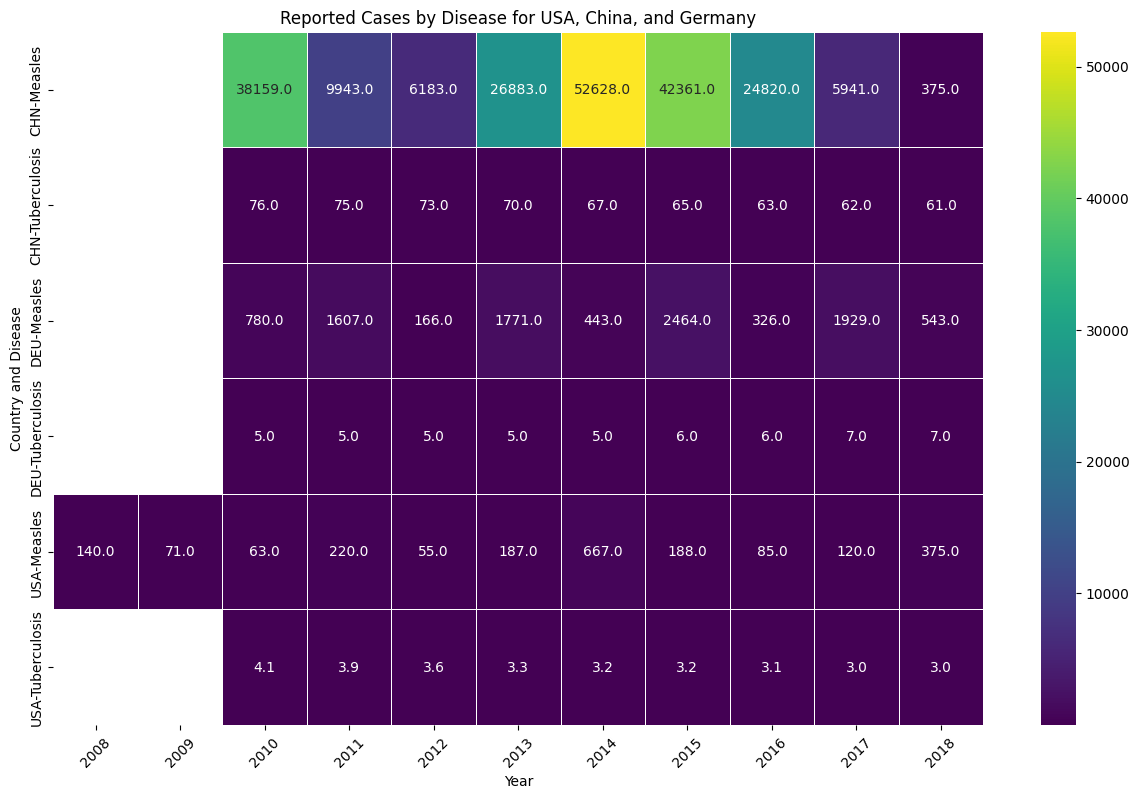

In [39]:
#disease prevalence graph
import seaborn as sns
import matplotlib.pyplot as plt


combined_data = {
    ('USA', 'Measles'): {
        2008: 140, 2009: 71, 2010: 63, 2011: 220, 2012: 55, 2013: 187, 2014: 667, 2015: 188, 2016: 85, 2017: 120, 2018: 375
    },
    ('USA', 'Tuberculosis'): {
        2010: 4.1, 2011: 3.9, 2012: 3.6, 2013: 3.3, 2014: 3.2, 2015: 3.2, 2016: 3.1, 2017: 3, 2018: 3
    },
    ('CHN', 'Measles'): {
        2010: 38159, 2011: 9943, 2012: 6183, 2013: 26883, 2014: 52628, 2015: 42361, 2016: 24820, 2017: 5941, 2018: 375
    },
    ('CHN', 'Tuberculosis'): {
        2010: 76, 2011: 75, 2012: 73, 2013: 70, 2014: 67, 2015: 65, 2016: 63, 2017: 62, 2018: 61
    },
    ('DEU', 'Measles'): {
        
        2010: 780, 2011: 1607, 2012: 166, 2013: 1771, 2014: 443, 2015: 2464, 2016: 326, 2017: 1929, 2018: 543
    },
    ('DEU', 'Tuberculosis'): {
        2010: 5, 2011: 5, 2012: 5, 2013: 5, 2014: 5, 2015: 6, 2016: 6, 2017: 7, 2018: 7
    }
}

# Convert combined data into a DataFrame for heatmap visualization
df_list = []
for (country, disease), years_data in combined_data.items():
    for year, cases in years_data.items():
        df_list.append([country, disease, year, cases])

# Create DataFrame
df_heatmap = pd.DataFrame(df_list, columns=['Country', 'Disease', 'Year', 'Cases'])

# Pivot DataFrame to get the proper format for the heatmap
df_pivot = df_heatmap.pivot_table(index=['Country', 'Disease'], columns='Year', values='Cases')

# Creating the heatmap for USA, China, and Germany
plt.figure(figsize=(15, 9))
sns.heatmap(df_pivot, cmap="viridis", annot=True, fmt=".1f", linewidths=.5)
plt.title('Reported Cases by Disease for USA, China, and Germany')
plt.ylabel('Country and Disease')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.show()



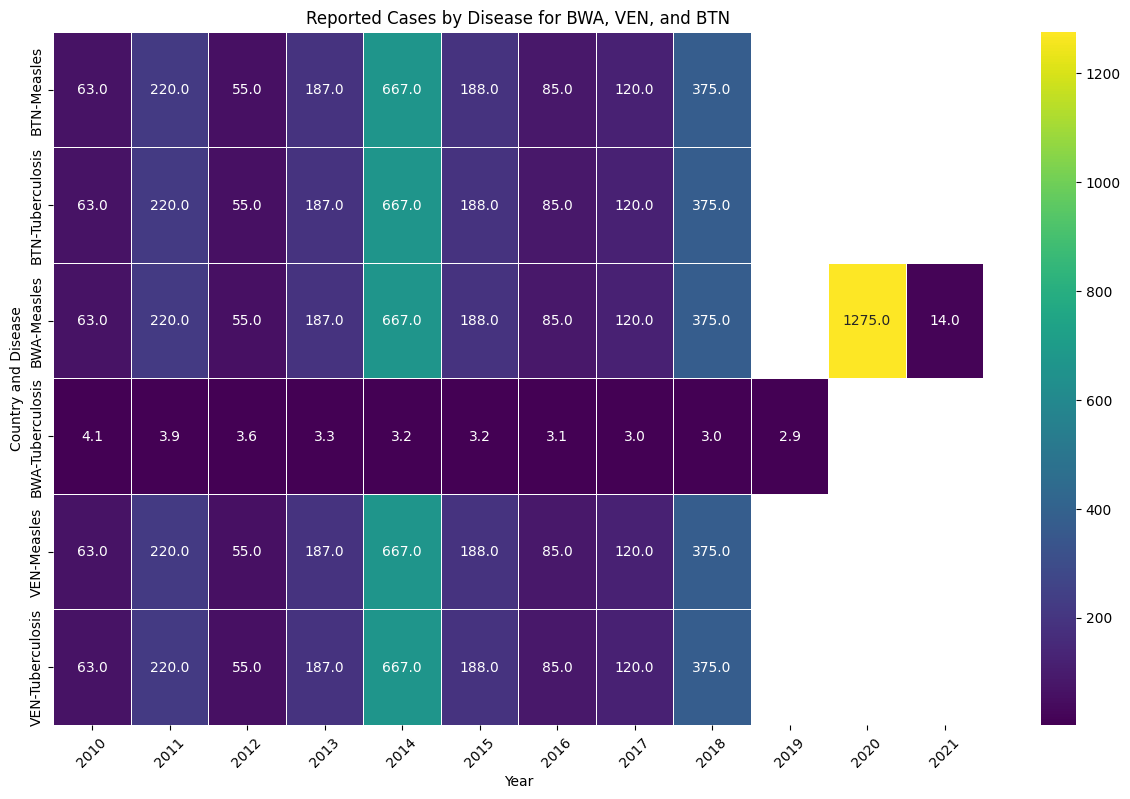

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_data = {
    ('BWA', 'Measles'): {
        2010: 63, 2011: 220, 2012: 55, 2013: 187, 2014: 667, 2015: 188, 2016: 85, 2017: 120, 2018: 375,
        2020: 1275, 2021: 14
    },
    ('BWA', 'Tuberculosis'): {
        2010: 4.1, 2011: 3.9, 2012: 3.6, 2013: 3.3, 2014: 3.2, 2015: 3.2, 2016: 3.1, 2017: 3, 2018: 3, 2019: 2.9
    },
    ('VEN', 'Measles'): {
        2010: 63, 2011: 220, 2012: 55, 2013: 187, 2014: 667, 2015: 188, 2016: 85, 2017: 120, 2018: 375
    },
    ('VEN', 'Tuberculosis'): {
        2010: 63, 2011: 220, 2012: 55, 2013: 187, 2014: 667, 2015: 188, 2016: 85, 2017: 120, 2018: 375
    },
    ('BTN', 'Measles'): {
        2010: 63, 2011: 220, 2012: 55, 2013: 187, 2014: 667, 2015: 188, 2016: 85, 2017: 120, 2018: 375
    },
    ('BTN', 'Tuberculosis'): {
        2010: 63, 2011: 220, 2012: 55, 2013: 187, 2014: 667, 2015: 188, 2016: 85, 2017: 120, 2018: 375
    }
}

# Convert combined data into a DataFrame for heatmap visualization
df_list = []
for (country, disease), years_data in combined_data.items():
    for year, cases in years_data.items():
        df_list.append([country, disease, year, cases])

# Create DataFrame
df_heatmap = pd.DataFrame(df_list, columns=['Country', 'Disease', 'Year', 'Cases'])

# Pivot DataFrame to get the proper format for the heatmap
df_pivot = df_heatmap.pivot_table(index=['Country', 'Disease'], columns='Year', values='Cases')

# Creating the heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(df_pivot, cmap="viridis", annot=True, fmt=".1f", linewidths=.5)
plt.title('Reported Cases by Disease for BWA, VEN, and BTN')
plt.ylabel('Country and Disease')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.show()
